# 04 Reinforcement Learning Tutorial
 > # Q-Learning
 >__Created__:  December 2020 Harrison B. Prosper<p>
 > Inspired by Manuel Amunategui's example at:<p> 
 https://amunategui.github.io/reinforcement-learning

## Introduction
Reinforcement learning is a class of algorithms for learning optimal strategies, that is, $(state, action)$ pairs, through trial and error guided by current and estimated future expected rewards. This class of algorithms is particularly suited for activities that can be construed as games with well-defined rules. Here we review the basics of an algorithm called $Q$-learning.

### Definitions
  1. __environment__: a configuration of objects. The objects could be, for example, pixels in a 2D image.
  1. __state__: a set of attributes, $s$, that characterize the environment at a given time $t$. This could be, for example, the values of the pixels.
  1. __action__: a manipulation of the environment that causes it to transition to another state. Abstractly, an action, $a$, is the mapping $a: s \rightarrow s^\prime$, where $s$ is the current state and $s^\prime$ is the state to which the environment transitions. The mapping 
  can be modeled as a tuple: $(s, s^\prime)$.
  1. __reward__: the $immediate$ reward $R(s, a)$ associated with the action $a: s \rightarrow s^\prime$.
  1. __agent__: an automaton, e.g., a bot, that can take actions that cause the environment to transition from one state to another.
  1. __policy__: a method for choosing an action, $a$, in a given state, $s$. 
  1. __target state__: the desired state, $s^*$, to be reached by executing a sequence of actions determined by a policy.
  1. __Q function__: the $expected$ reward $Q(s, a)$ associated with action $a$ in state $s$. This is the function to be estimated by the training algorithm and the basis of the policy to be followed.
 
A transition from the one state to another may depend on previous states. However, the Q-learning algorithm assumes the Markov property:  *the transition from one state to another depends only on the current state*. The following rule [1],  called the __Temporal Difference Update__,

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] ,
\end{align}

has been shown to converge [2] to a function $Q^*(s, a)$ that maximizes the expected reward from state $s$ to the target state, $s^*$. The quantities $$0 < \alpha \leq 1 \textrm{ and } 0 < \gamma < 1$$ are hyperparameters. The hyperparameter $\alpha$ determines how much of the future expected reward is to be taken into account during training relative to the current expected reward, while $\gamma$ is the amount by which a future expected reward is to be discounted relative to the immediate reward $R$.

## Tutorial
In this tutorial the environment can be thought of as a 2-pixel image, modeled as a tuple $(x, y)$ with $x, y \in X \subset \mathbb{J}$ [3]. Since the environment contains only 2 pixels $x$ and $y$, its states can be visualized as points in a regular 2-D grid. In an $n$-pixel image each state (that is, image) would be a point in a regular $n$-D grid. In either case, a history, or episode, of the environment is a contiguous path that connects grid points. The set of histories form a graph in which the states, $s$, are represented by the nodes of the graph and the actions, $a: s \rightarrow s^\prime$, are represented by directed edges between nodes. 

Of course, in the 2-pixel case, we can also just regard the 2-D graph as a 2-D maze to be navigated!

<br>

### References
  1. Christopher J.C.H Watkins, *Learning from delayed rewards*, PhD Thesis, University of Cambridge, England (1989).
  1. Christopher J.C.H. Watkins and Peter Dayan, *Technical Note $Q$-Learning*, Machine Learning, __8__, 279-292 (1992).
  1. $\mathbb{J}$ is the set if all non-negative integers.

In [1]:
# standard modules
import os, sys, time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# a nice module to handle graphs (in this context, a graph 
# is a network of nodes with directed edges between them).
# to install the module do
#   conda install networkx
# within your miniconda3 environment
import networkx as nx

# draw graphs inline
%matplotlib inline

In [33]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set a seed to ensure reproducibility
seed = 111
rnd  = np.random.RandomState(seed)

mp.rc('text', usetex=False)

### Define available states and actions 
The states form a 2-D grid of points, while actions are edges between points. 

<br>

Create nodes

In [34]:
# ---------------------------------------------
# size of grid
# ---------------------------------------------
xmin, xmax = 0, 6
ymin, ymax = 0, 6
x_limits   = (xmin, xmax)
y_limits   = (ymin, ymax)
# ---------------------------------------------
# create all possible nodes
# ---------------------------------------------
xx     = np.arange(xmin+1, xmax, 1)
yy     = np.arange(ymin+1, ymax, 1)
xx, yy = np.meshgrid(xx, yy)
# ---------------------------------------------
# convert meshgrid into a list of tuples 
# ---------------------------------------------
nodes  = [(x, y) for x, y in zip(xx.flatten(), 
                                 yy.flatten())]
nodes  = set(nodes)

Create edges

In [35]:
all_edges = []
for pos in nodes:
    x, y  = pos
    
    # go up one unit
    u_pos = (x, y+1)
    if u_pos in nodes:
        all_edges.append((pos, u_pos))
        
    # go right one unit
    r_pos = (x+1, y)
    if r_pos in nodes:
        all_edges.append((pos, r_pos))

# create graph from the edges
full_graph= nx.Graph()
full_graph.add_edges_from(all_edges)

In [46]:
def plot_graph(graph,         # set of histories
               filename=None,
               history=[],    # a history to be highlighted
               xlimits=x_limits, 
               ylimits=y_limits):

    # if a history is given, create from it a 
    # sequence (s_edges) of edges from it
    s_edges = []
    if len(history) > 0:
        i_node = history[0]
        for j_node in history[1:]:
            s_edges.append((i_node, j_node))
            i_node = j_node 
    s_edges = set(s_edges)
    
    # color edges. if an edge connects two adjacent
    # nodes of the given history, then color the edge 
    # blue, otherwise color the edge green.
    colors = []
    widths = []
    for edge in graph.edges:
        # reverse order of elements in tuple edge
        r_edge  = edge[::-1]
        
        # if edge or r_edge is in the set of edges
        # s_edges constructed from the history, color
        # the edge blue otherwise color it green.
        matched = (edge in s_edges) or (r_edge in s_edges)
        if matched:
            colors.append('blue')
            widths.append(3)
        else:
            colors.append('green')
            widths.append(1)
        
    # set up an empty figure
    fig = plt.figure(figsize=(5, 5))
    ax  = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)

    # get positions of nodes
    nodes = {}
    for node in graph:
        nodes[node] = node
        
    # finally, draw graph!
    nx.draw_networkx(graph, 
                     pos=nodes,
                     node_color='orange',
                     edge_color=colors,
                     with_labels=True,
                     width=widths, 
                     ax=ax)
    
    # apparently, this is needed to make
    # the axes appear!
    ax.tick_params(left=True, 
                   bottom=True, 
                   labelleft=True, 
                   labelbottom=True)
    fig.tight_layout()
    
    if filename != None:
        mp.rc('text', usetex=True)
        plt.savefig(filename)
        
    plt.show()

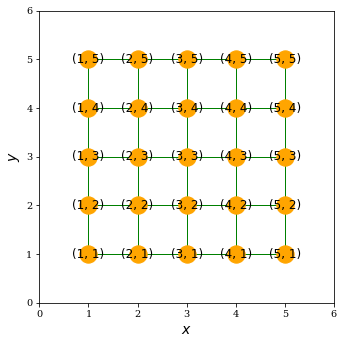

In [37]:
plot_graph(full_graph)

Randomly delete edges

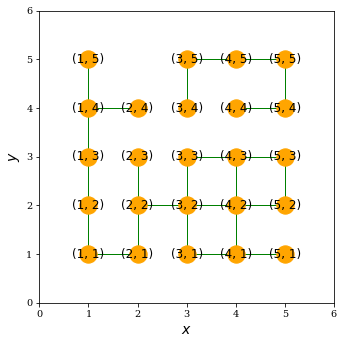

In [38]:
rnd.shuffle(all_edges)
n_edges = 25
edges   = all_edges[:n_edges]
graph   = nx.Graph()
graph.add_edges_from(edges)
plot_graph(graph)

Add more edges as needed to eliminate disconnected sub-graphs.

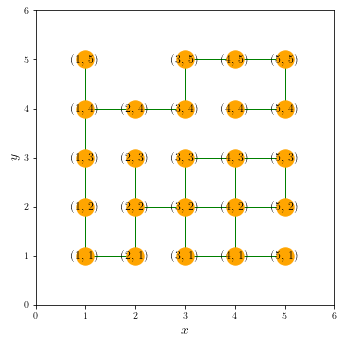

In [47]:
edges.append(((2,4), (3,4)))
graph = nx.Graph()
graph.add_edges_from(edges)
plot_graph(graph, filename='04_grid.png')

### Target state
Based on the image above, choose target state.

In [40]:
target_state = (4, 4)

### Model environment
The states of the environment, itself modeled by the class *Environment*, are modeled as tuples $(x, y)$ with different integer values for the attributes $x$ and $y$. An action, $a$, is a mapping $a: (x, y) \rightarrow (x^\prime, y^\prime)$ in which the attributes $x, x^\prime$ and $y, y^\prime$ differ, at most, by one unit. The environment class exports a few useful methods, such as *neighbors$(s)$* which returns, in a list, the nearest neighbor states connected to state $s$. Given the pair $(s, a)$, the environment returns the value of the immediate award $R(s, a)$ as well as the next state of the environment $s^\prime$. Note, since in this example, $R(s, a)$ depends on $s^*$, the environment needs to "know" the desired target state $s^*$.

In this example, the immediate reward function is rather simple

\begin{align}
R(s, a) & = \begin{cases}
                r, & \text{if } s^\prime = s^*, \textrm{ where } a: s \rightarrow s^\prime \\
                0  & \text{otherwise};
            \end{cases}
\end{align}
the agent gets an immediate reward if its action transitions the environment to the target state, otherwise the agent gets nothing.

One can of course construct much more elaborate functions $R(s, a)$. A more complicated immediate reward function would take into account the possibility that some actions are more difficult than others. For example, suppose the 2-D grid of points represents actual positions in a mountainous terrain and the goal is to reach a low-lying settlement from any point in the terrian by following a path requiring the least amount of effort. A possible immediate reward function for action $a: s \rightarrow s^\prime$, in this case, might be

\begin{align}
R(s, a) & = \begin{cases}
                +r &  \text{if } s^\prime = s^* \\
               -r f & \text{if } f = [h(s^\prime) - h(s)] \, / \, h(s^\prime) > 0  \\ 
                0 & \text{otherwise}, 
            \end{cases}
\end{align}

where $h(s)$ is the height of the terrain at position $s$. This reward function favors actions that penalize climbing while not penalizing gentle or descending paths. 

A possible issue with such a reward function is that it may cause the agent to get stuck in a high mountain valley. It is therefore vital that sufficient random exploration occurs during training in order to avoid converging to a policy that allows this undesirable outcome.

In [48]:
class Environment:
    '''
 Help on class Environment:

 class Environment
  |  Environment(graph, target_state, r=1.0)
  |
  |  Model an environment whose states are modeled by tuples (x, y),
  |  where x and y are non-negative integers.
  |
  |  Parameters
  |  ----------
  |  graph         : graph defining the set of environment histories.
  |  target_state  : desired final state of environment.
  |  r             : immediate reward given to agent if its action 
  |                  transitions the environment to the target state 
  |                  (default = 1.0).
    '''
    def __init__(self, graph, target_state, r=1.0):
        
        self.graph  = graph  
        self.target = target_state
        self.r      = r
        self.state  = None
        
    def __del__(self):
        pass
    
    def __len__(self):
        return self.number_of_states()
    
    def number_of_states(self):
        return len(self.graph)
    
    def number_of_actions(self):
        return len(self.graph.edges)
        
    def current_state(self):
        return self.state
    
    def target_state(self):
        return self.target
           
    def max_reward(self):
        return self.r
    
    def states(self):
        return list(self.graph)
         
    def actions(self):
        return list(self.graph.edges)
    
    def neighbors(self, state):
        if state in self.graph:
            return list(self.graph[state])
        else:
            return None
        
    # implement action a: state => next_state
    def step(self, state, action):
        self.state = state
        
        # make sure we have a valid (state, action) pair
        states = self.neighbors(state)
        if states == None:        return (state, -self.r)
        if action <  0:           return (state, -self.r)
        if action >= len(states): return (state, -self.r)
        
        # compute immediate reward
        r = self.r if states[action] == self.target else 0
        
        # transition to next state
        next_state = states[action]
        self.state = next_state
        
        return (next_state, r)

In [49]:
env = Environment(graph, target_state)

### Model $Q(s, a)$ function

Trained using: __Temporal Difference Update__,

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] .
\end{align}

In [50]:
class Qfunction:    
    def __init__(self, env, 
                 gamma=0.9, alpha=1.0, epsilon=1.0, depsilon=0.0):
        
        # cache inputs, including the environment
        self.env      = env             
        self.gamma    = gamma
        self.alpha    = alpha
        self.epsilon  = epsilon
        self.depsilon = depsilon
        self.p        = 1 - epsilon
        self.scores   = []
        
        # initialize Q function to zero forall pairs (s, a)
        self.Q = {} # Q values
        for state in env.states():
            self.Q[state] = [0]*len(env.neighbors(state))

    def __del__(self):
        pass
    
    def __call__(self, state, action):
        Q = self.Q
        if state not in Q:
            return -1
        if action < 0:
            return -2
        if action >= len(Q[state]):
            return -3
        return Q[state][action]
    
    def __str__(self):
        Q      = self.Q
        env    = self.env
        states = list(Q.keys())
        states.sort()
        
        s_str = ''
        for i, s in enumerate(states):
            qq = Q[s]
            nn = env.neighbors(s)
            
            x, y = s
            s_str += '%5d (%2d,%2d) =>' % (i,x,y)
            
            for n in nn: s_str += ' (%2d,%2d)' % n
            s_str += '\n%16s' % ''
            
            for q in qq: s_str += ' %6.3f ' % q
            s_str += '\n'
            
        return s_str[:-1]
    
    def update(self, state, action):
        gamma = self.gamma
        alpha = self.alpha
        Q     = self.Q
        env   = self.env
        
        # get next state and reward associated with
        # action a: state => next_state
        next_state, reward = env.step(state, action)
        
        # update Q value
        # note: if alpha = 0.0, the agent learns nothing.
        #       if alpha = 1.0, the agent relies solely on
        #       the current expected reward and not at all 
        #       on prior estimates of the expected reward.
        # gamma < 1 implies that future rewards are discounted
        # relative to immediate rewards and the discount increases
        # geometrically the more distant the future is from the
        # present.
        
        s = state
        a = action
        n = next_state
        
        # for state n, get the action k with the largest Q value
        k = np.argmax(Q[n])
        
        # update Q function
        Q[s][a] = (1 - alpha)*Q[s][a] + alpha*(reward + gamma*Q[n][k])
        
        # compute a score
        sum_Q = self.sum_Q()
        max_Q = self.max_Q()
        max_R = env.max_reward()
        score = max_R * sum_Q / max_Q if max_Q > 0 else 0
        return score
    
    def pick_state(self):
        Q = self.Q
        k = rnd.randint(len(Q))
        return list(Q.keys())[k]
    
    def pick_action(self, state):
        Q = self.Q
        if state not in Q: return None
        if len(Q[state]) == 0: return None
        
        # implement epsilon greedy policy:
        #   for the given state, pick with probability 
        #   p = 1 - epsilon the action with the largest Q value 
        #   else pick a random action.
        u = np.random.uniform()
        if u < self.p:
            # pick action with the largest Q value
            a = np.argmax(Q[state])
        else:
            # pick a random action
            a = rnd.randint(len(Q[state]))
        return a
        
    def train(self, n_iterations=4001):
        
        for ii in range(n_iterations):
            
            # pick a state at random
            state  = self.pick_state()
            
            # pick action according to an 
            # epsilon-greedy policy
            action = self.pick_action(state)
            
            # update Q function
            score  = self.update(state, action)
            
            # print score
            self.scores.append(score)
            print('\r%5d\tscore: %10.2f' % (ii, score), end='')
            time.sleep(0.001)
         
    def sum_Q(self):
        Q     = self.Q
        states= list(Q.keys())
        sum_q = 0.0
        for s in states: 
            sum_q += sum(Q[s])
        return sum_q
         
    def max_Q(self):
        Q     = self.Q
        states= list(Q.keys())
        max_q = 0.0
        for s in states: 
            x = max(Q[s])
            if x > max_q: max_q = x
        return max_q
            
    def set_Q(self, Q):
        self.Q = Q
        
    def get_Q(self):
        return self.Q
    
    def get_path(self, state):
        # use greedy policy: 
        # choose action with largest Q value.
        start = state
        path  = [start]
        
        Q     = self.Q
        env   = self.env
        target= env.target_state()
        max_it= 10 * len(Q)
        
        ii = 0
        while (state != target) and (ii < max_it):
            ii += 1
            # get action with highest Q for given state
            action = np.argmax(Q[state])
            
            # get the next state using optimal action
            next_state = env.neighbors(state)[action]
            
            # if the next_state is already in the current
            # path, then assume that the agent is lost!
            if next_state in set(path):
                print('agent is lost along path %s => %s!' % \
                      (start, next_state))
                path = []
                break
                    
            # continue building path
            path.append(next_state)
            state = next_state
        return path

### Now train $Q$!

In [59]:
Q = Qfunction(env)
Q.train()

 4000	score:      20.41

In [60]:
def plot_scores(scores): 
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_ylim((0, 1.1*max(scores)))
    ax.set_xlim((0, len(scores)))
    
    ax.plot(scores, 'b')
    ax.set_xlabel('iterations', fontsize=16)
    ax.set_ylabel('score', fontsize=16)
    ax.grid(True, which="both", linestyle='-')

    plt.show()

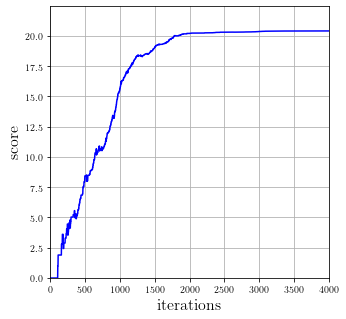

In [61]:
scores = Q.scores
plot_scores(Q.scores)

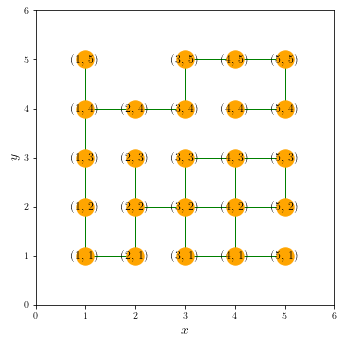

Q-function
    0 ( 1, 1) => ( 2, 1) ( 1, 2)
                  1.652   2.039 
    1 ( 1, 2) => ( 1, 3) ( 1, 1)
                  2.265   1.835 
    2 ( 1, 3) => ( 1, 4) ( 1, 2)
                  2.517   2.039 
    3 ( 1, 4) => ( 1, 3) ( 1, 5) ( 2, 4)
                  2.265   2.265   2.797 
    4 ( 1, 5) => ( 1, 4)
                  2.517 
    5 ( 2, 1) => ( 2, 2) ( 1, 1)
                  1.486   1.835 
    6 ( 2, 2) => ( 3, 2) ( 2, 1) ( 2, 3)
                  1.338   1.652   1.338 
    7 ( 2, 3) => ( 2, 2)
                  1.486 
    8 ( 2, 4) => ( 1, 4) ( 3, 4)
                  2.517   3.108 
    9 ( 3, 1) => ( 3, 2) ( 4, 1)
                  1.338   1.083 
   10 ( 3, 2) => ( 2, 2) ( 3, 3) ( 4, 2) ( 3, 1)
                  1.486   1.204   1.204   1.204 
   11 ( 3, 3) => ( 3, 2) ( 4, 3)
                  1.338   1.083 
   12 ( 3, 4) => ( 3, 5) ( 2, 4)
                  3.453   2.797 
   13 ( 3, 5) => ( 3, 4) ( 4, 5)
                  3.108   3.837 
   14 ( 4, 1) => ( 4, 2) ( 5, 1) 

In [62]:
plot_graph(graph)
print('Q-function')
print(Q)

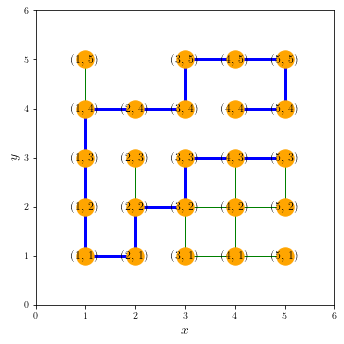

In [65]:
start= (5,3)
path = Q.get_path(start)
plot_graph(graph, history=path, filename='04_maze_%d_%d.png' % start)